HW7 Мельчук А.Б.

    Запустить seq2seq, seq2seq с внимаием и трансформер для перевода русских слов + описать наблюдения по качеству
    Данные в папке data

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
batch_size = 64
epochs = 60
latent_dim = 256
num_samples = 10000
data_path = 'data/rus-eng/rus.txt'

In [4]:
# Собираем из текстов токены и делаем pne-hot вектора на каждый токен

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [6]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [7]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [8]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Epoch 1/60
125/125 [==============================] - 2s 18ms/step - loss: 1.1304 - accuracy: 0.7745 - val_loss: 0.9147 - val_accuracy: 0.7586
Epoch 2/60
125/125 [==============================] - 2s 12ms/step - loss: 0.7338 - accuracy: 0.8031 - val_loss: 0.7792 - val_accuracy: 0.7959
Epoch 3/60
125/125 [==============================] - 2s 12ms/step - loss: 0.6327 - accuracy: 0.8325 - val_loss: 0.6907 - val_accuracy: 0.8117
Epoch 4/60
125/125 [==============================] - 2s 12ms/step - loss: 0.6255 - accuracy: 0.8362 - val_loss: 0.6558 - val_accuracy: 0.8183
Epoch 5/60
125/125 [==============================] - 2s 13ms/step - loss: 0.5447 - accuracy: 0.8478 - val_loss: 0.6145 - val_accuracy: 0.8255
Epoch 6/60
125/125 [==============================] - 2s 13ms/step - loss: 0.5154 - accuracy: 0.8540 - val_loss: 0.5891 - val_accuracy: 0.8328
Epoch 7/60
125/125 [==============================] - 2s 12ms/step - loss: 0.4951 - accuracy: 0.8587 - val_loss: 0.5702 - val_accuracy: 0.8363

Epoch 58/60
125/125 [==============================] - 2s 12ms/step - loss: 0.1362 - accuracy: 0.9587 - val_loss: 0.4764 - val_accuracy: 0.8841
Epoch 59/60
125/125 [==============================] - 2s 13ms/step - loss: 0.1323 - accuracy: 0.9600 - val_loss: 0.4808 - val_accuracy: 0.8841
Epoch 60/60
125/125 [==============================] - 2s 13ms/step - loss: 0.1276 - accuracy: 0.9613 - val_loss: 0.4863 - val_accuracy: 0.8834
-
Input sentence: Go.
Decoded sentence: Идите.

-
Input sentence: Go.
Decoded sentence: Идите.

-
Input sentence: Go.
Decoded sentence: Идите.

-
Input sentence: Hi.
Decoded sentence: Здравствуйте.

-
Input sentence: Hi.
Decoded sentence: Здравствуйте.

-
Input sentence: Hi.
Decoded sentence: Здравствуйте.

-
Input sentence: Hi.
Decoded sentence: Здравствуйте.

-
Input sentence: Hi.
Decoded sentence: Здравствуйте.

-
Input sentence: Run!
Decoded sentence: Беги!

-
Input sentence: Run!
Decoded sentence: Беги!

-
Input sentence: Run.
Decoded sentence: Бегите!

-
I

Увеличение количества эпох до 60ти сильно повысило качество перевода. 

## Поднимемся на уровень слов, чтобы можно было что-то более адекватное посчитать за адекватное время

In [11]:
import re
import tensorflow as tf
data_path = 'data/rus-eng/rus.txt'
num_samples = 10000

# tf.enable_eager_execution()

input_texts = []
target_texts = []

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence(target_text))

In [12]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [13]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [14]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [18]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [19]:
EPOCHS = 10
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 0.1044
Epoch 2 Loss 0.0296
Epoch 3 Loss 0.0241
Epoch 4 Loss 0.0204
Epoch 5 Loss 0.0189
Epoch 6 Loss 0.0173
Epoch 7 Loss 0.0159
Epoch 8 Loss 0.0254
Epoch 9 Loss 0.0179
Epoch 10 Loss 0.0150


Некоторые украденные функции для оценки

In [20]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
!conda install ticker

Populating the interactive namespace from numpy and matplotlib
Input: <start> good morning <end>
Predicted translation: ! <end> 


/home/ai/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['char', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


NameError: name 'ticker' is not defined

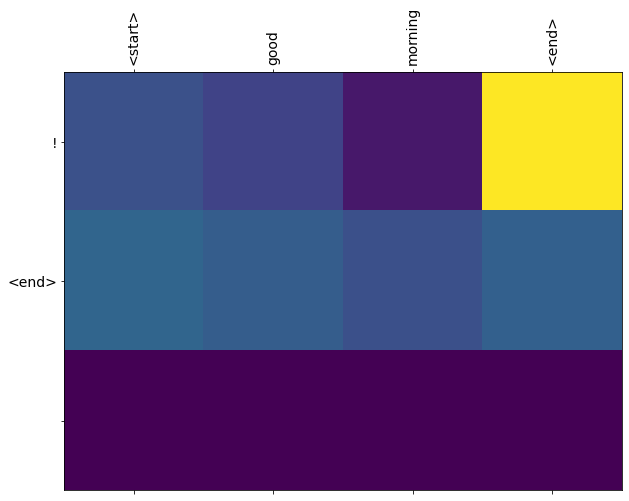

In [21]:
%pylab inline

translate(u'good morning')

In [36]:
translate(u'hello')

Input: hello
Predicted translation: ['<start>', '!']


### Transformer

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [25]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [27]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(inp_lang_tokenizer.index_word) + 2
target_vocab_size = len(targ_lang_tokenizer.index_word) + 2
dropout_rate = 0.1

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [29]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [30]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [31]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [32]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [33]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [34]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

for epoch in range(100):
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

Epoch 1 Batch 0 Loss 4.2216 Accuracy 0.0117
Epoch 1 Batch 50 Loss 2.4525 Accuracy 0.1241
Epoch 1 Batch 100 Loss 1.7703 Accuracy 0.1908
Epoch 1 Loss 1.5871 Accuracy 0.2230
Epoch 2 Batch 0 Loss 0.5561 Accuracy 0.4219
Epoch 2 Batch 50 Loss 0.3254 Accuracy 0.4613
Epoch 2 Batch 100 Loss 0.2397 Accuracy 0.4738
Epoch 2 Loss 0.2204 Accuracy 0.4769
Epoch 3 Batch 0 Loss 0.1155 Accuracy 0.4961
Epoch 3 Batch 50 Loss 0.1179 Accuracy 0.4923
Epoch 3 Batch 100 Loss 0.1173 Accuracy 0.4922
Epoch 3 Loss 0.1172 Accuracy 0.4920
Epoch 4 Batch 0 Loss 0.2580 Accuracy 0.4883
Epoch 4 Batch 50 Loss 0.1101 Accuracy 0.4928
Epoch 4 Batch 100 Loss 0.1043 Accuracy 0.4921
Epoch 4 Loss 0.1024 Accuracy 0.4922
Epoch 5 Batch 0 Loss 0.0959 Accuracy 0.4922
Epoch 5 Batch 50 Loss 0.0856 Accuracy 0.4933
Epoch 5 Batch 100 Loss 0.0847 Accuracy 0.4927
Epoch 5 Loss 0.0853 Accuracy 0.4925
Epoch 6 Batch 0 Loss 0.0864 Accuracy 0.4961
Epoch 6 Batch 50 Loss 0.0724 Accuracy 0.4944
Epoch 6 Batch 100 Loss 0.0773 Accuracy 0.4940
Epoch 6 Lo

Epoch 48 Batch 50 Loss 0.0422 Accuracy 0.4959
Epoch 48 Batch 100 Loss 0.0458 Accuracy 0.4955
Epoch 48 Loss 0.0485 Accuracy 0.4954
Epoch 49 Batch 0 Loss 0.1578 Accuracy 0.4922
Epoch 49 Batch 50 Loss 0.0545 Accuracy 0.4948
Epoch 49 Batch 100 Loss 0.0481 Accuracy 0.4953
Epoch 49 Loss 0.0482 Accuracy 0.4954
Epoch 50 Batch 0 Loss 0.0366 Accuracy 0.4922
Epoch 50 Batch 50 Loss 0.0450 Accuracy 0.4945
Epoch 50 Batch 100 Loss 0.0517 Accuracy 0.4952
Epoch 50 Loss 0.0508 Accuracy 0.4952
Epoch 51 Batch 0 Loss 0.0161 Accuracy 0.4961
Epoch 51 Batch 50 Loss 0.0423 Accuracy 0.4962
Epoch 51 Batch 100 Loss 0.0500 Accuracy 0.4954
Epoch 51 Loss 0.0544 Accuracy 0.4952
Epoch 52 Batch 0 Loss 0.0502 Accuracy 0.4922
Epoch 52 Batch 50 Loss 0.0742 Accuracy 0.4941
Epoch 52 Batch 100 Loss 0.0660 Accuracy 0.4939
Epoch 52 Loss 0.0647 Accuracy 0.4939
Epoch 53 Batch 0 Loss 0.0534 Accuracy 0.4961
Epoch 53 Batch 50 Loss 0.0457 Accuracy 0.4958
Epoch 53 Batch 100 Loss 0.0475 Accuracy 0.4954
Epoch 53 Loss 0.0491 Accuracy 0.

Epoch 95 Batch 50 Loss 0.0501 Accuracy 0.4968
Epoch 95 Batch 100 Loss 0.0620 Accuracy 0.4940
Epoch 95 Loss 0.0589 Accuracy 0.4938
Epoch 96 Batch 0 Loss 0.0497 Accuracy 0.5000
Epoch 96 Batch 50 Loss 0.0623 Accuracy 0.4941
Epoch 96 Batch 100 Loss 0.0556 Accuracy 0.4940
Epoch 96 Loss 0.0552 Accuracy 0.4940
Epoch 97 Batch 0 Loss 0.0055 Accuracy 0.5000
Epoch 97 Batch 50 Loss 0.0549 Accuracy 0.4944
Epoch 97 Batch 100 Loss 0.0527 Accuracy 0.4942
Epoch 97 Loss 0.0523 Accuracy 0.4942
Epoch 98 Batch 0 Loss 0.0172 Accuracy 0.4961
Epoch 98 Batch 50 Loss 0.0430 Accuracy 0.4963
Epoch 98 Batch 100 Loss 0.0492 Accuracy 0.4956
Epoch 98 Loss 0.0495 Accuracy 0.4952
Epoch 99 Batch 0 Loss 0.0202 Accuracy 0.4961
Epoch 99 Batch 50 Loss 0.0492 Accuracy 0.4959
Epoch 99 Batch 100 Loss 0.0482 Accuracy 0.4962
Epoch 99 Loss 0.0484 Accuracy 0.4961
Epoch 100 Batch 0 Loss 0.0348 Accuracy 0.5000
Epoch 100 Batch 50 Loss 0.0508 Accuracy 0.4953
Epoch 100 Batch 100 Loss 0.0508 Accuracy 0.4963
Epoch 100 Loss 0.0507 Accurac

In [35]:
def evaluate(inp_sentence):
    start_token = [1]
    end_token = [2]
  
    sentence = preprocess_sentence(inp_sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    
    encoder_input = tf.expand_dims(inputs, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = [1]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang_tokenizer.word_index["<end>"]:
            return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = inp_lang_tokenizer.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = ([targ_lang_tokenizer.index_word[i] for i in result.numpy()])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
translate("good morning.")

Input: good morning.
Predicted translation: ['<start>', '!']


In [38]:
translate("what is going on?")

Input: what is going on?
Predicted translation: ['<start>', '?']
